In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import great_tables as gt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
file_path = '/Users/noahberley/Desktop/INFO_6301_Final_Project/bike_share_dataset/hour.csv'
df = pd.read_csv(file_path)

# Preprocess the data
# Dropping 'instant' as it's just an index
# 'dteday' will be dropped as well, as 'yr', 'mnth', and 'hr' are more relevant for modeling
# Exclude 'registered' and 'casual' from the features
df = df.drop(['instant', 'dteday', 'registered', 'casual'], axis=1)

# Define the target variable and features
X = df.drop('cnt', axis=1)
y = df['cnt']


Summary Statistics:
             season            yr          mnth            hr       holiday  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       2.501640      0.502561      6.537775     11.546752      0.028770   
std        1.106918      0.500008      3.438776      6.914405      0.167165   
min        1.000000      0.000000      1.000000      0.000000      0.000000   
25%        2.000000      0.000000      4.000000      6.000000      0.000000   
50%        3.000000      1.000000      7.000000     12.000000      0.000000   
75%        3.000000      1.000000     10.000000     18.000000      0.000000   
max        4.000000      1.000000     12.000000     23.000000      1.000000   

            weekday    workingday    weathersit          temp         atemp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       3.003683      0.682721      1.425283      0.496987      0.475775   
std        2.005771      0.465

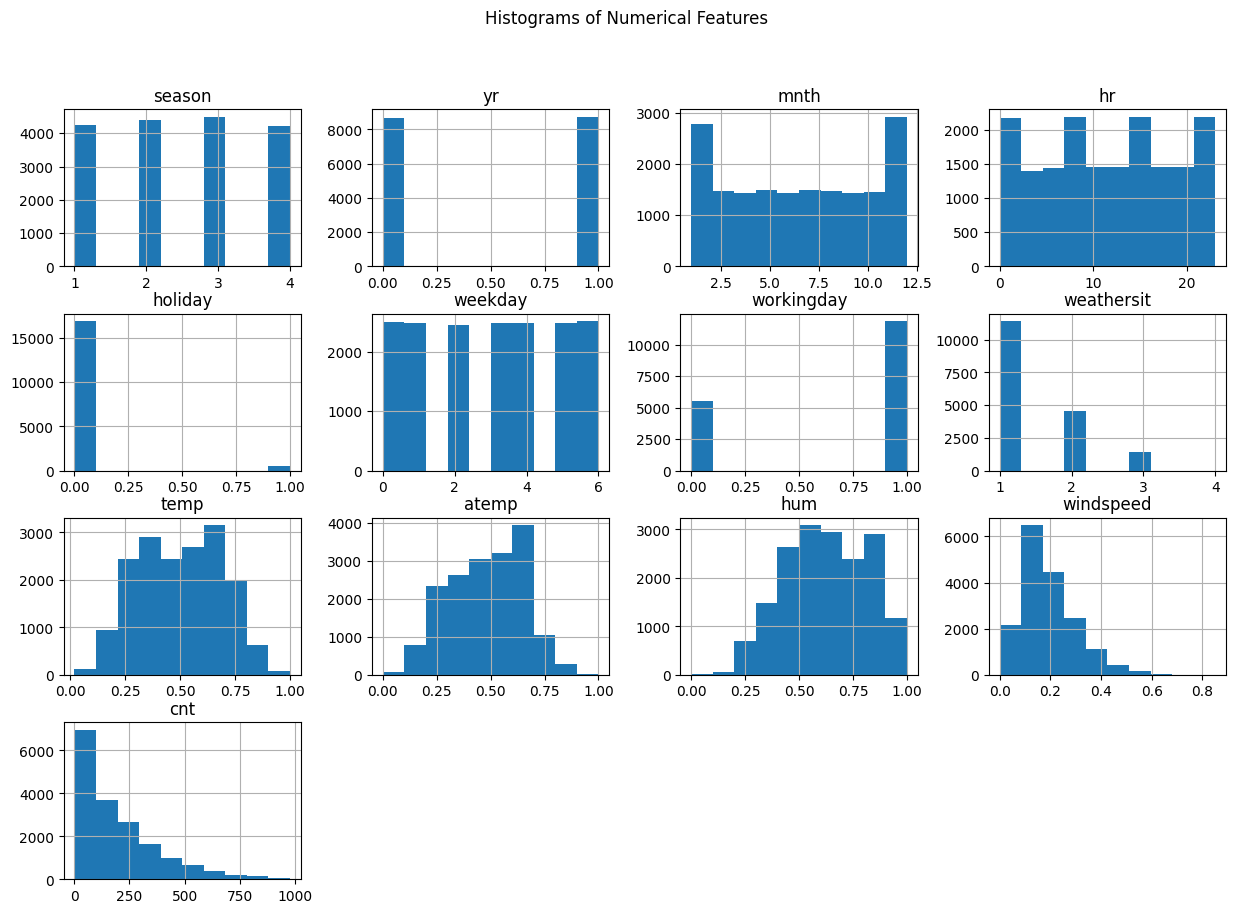

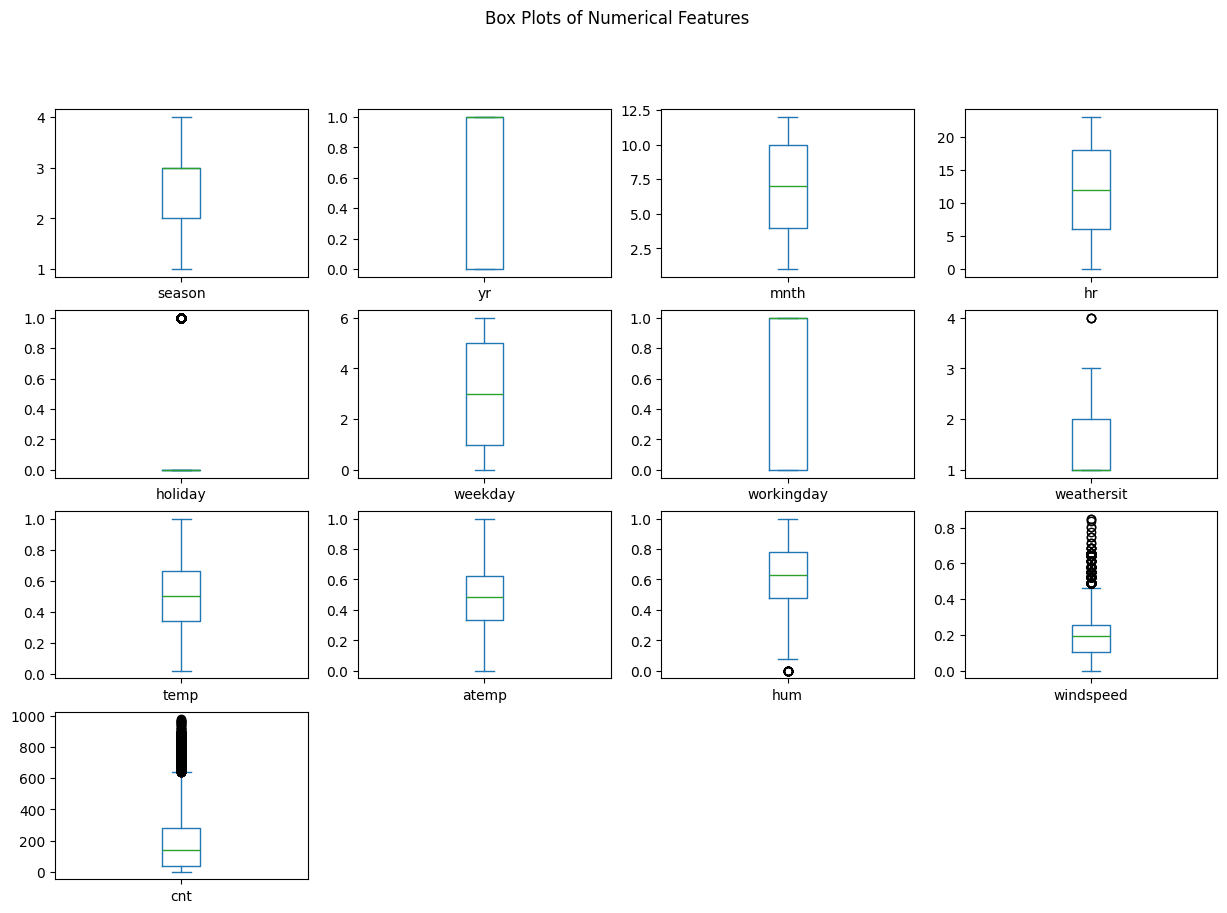

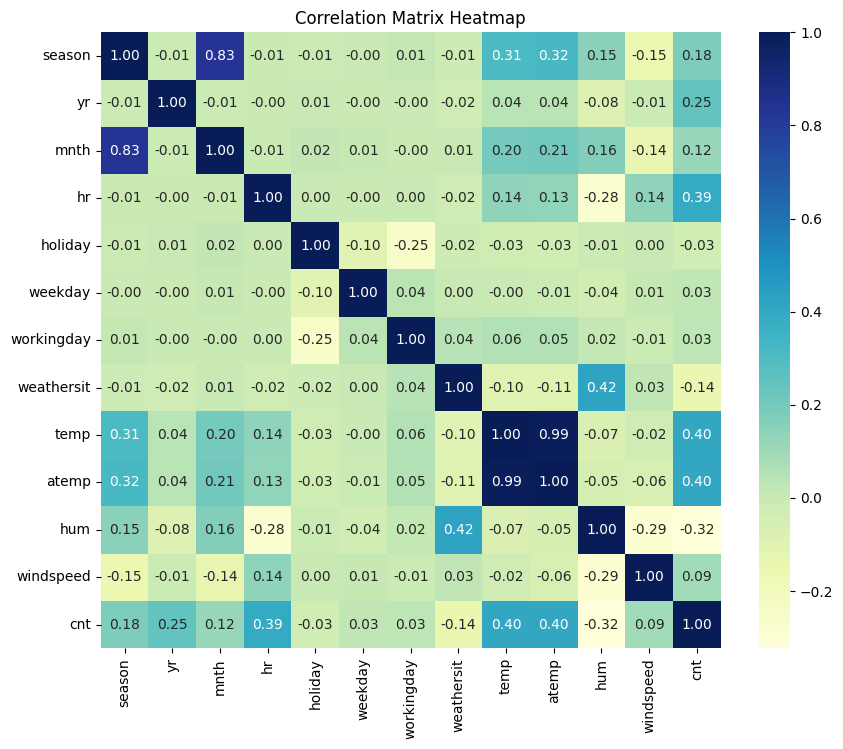

In [2]:
# Data Summary
# Summary statistics for numerical features
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Histograms for numerical features
df.hist(figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Box plots for numerical features
df.plot(kind='box', subplots=True, layout=(4, 4),
        sharex=False, sharey=False, figsize=(15, 10))
plt.suptitle('Box Plots of Numerical Features')
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Correlation Matrix Heatmap')
plt.show()

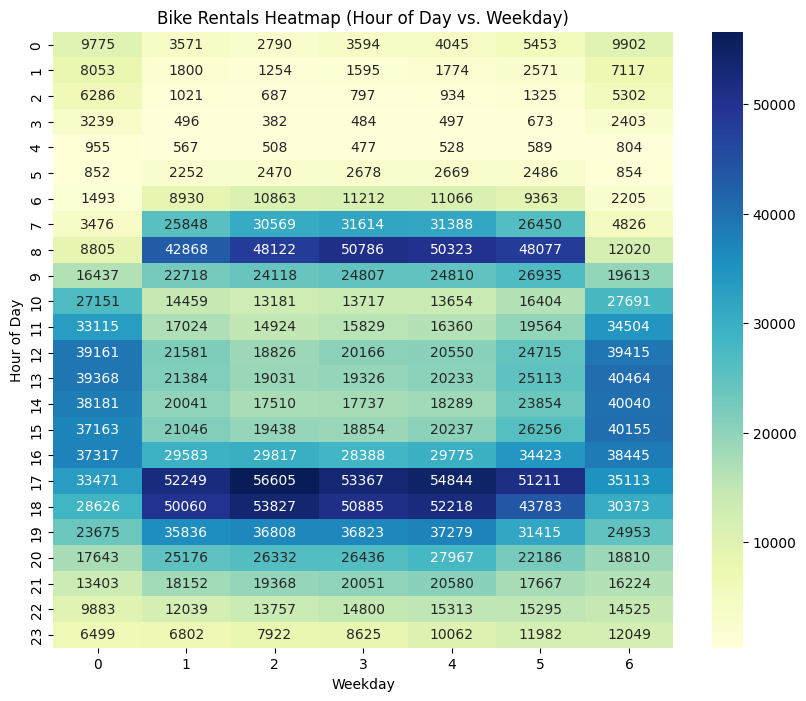

In [3]:
# Convert 'weekday' and 'hr' to categorical if they are not already
df['weekday'] = df['weekday'].astype('category')
df['hr'] = df['hr'].astype('category')

# Pivot the DataFrame to get hours on one axis and weekdays on the other
pivot_df = df.pivot_table(index='hr', columns='weekday', values='cnt', aggfunc='sum')

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, fmt="d", cmap="YlGnBu")

# Customizing the plot
plt.title('Bike Rentals Heatmap (Hour of Day vs. Weekday)')
plt.xlabel('Weekday')
plt.ylabel('Hour of Day')

# Show the plot
plt.show()

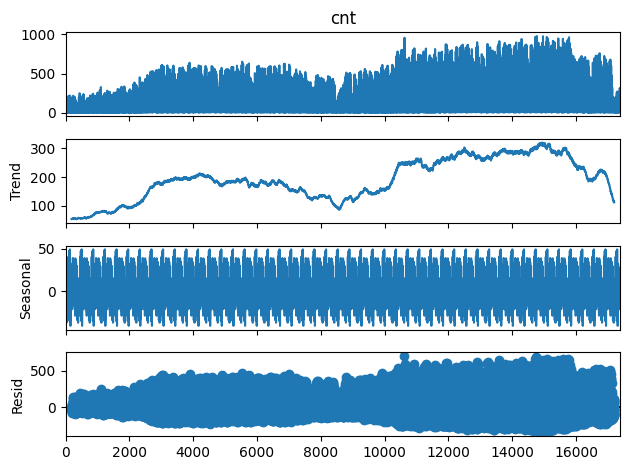

In [4]:
# Decompose the time series
result = seasonal_decompose(df['cnt'], model='additive', period=365)

# Plotting the decomposed time series components
result.plot()
plt.show()

In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
}

In [6]:
# Function to train, evaluate, and perform cross-validation on models
def train_evaluate_cv(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        # Cross-validation
        cv_scores = cross_val_score(model, X, y, cv=10)
        
        # Training and evaluation
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        
        results[name] = {'CV Mean Score': cv_scores.mean(), 'MSE': mse, 'R2 Score': r2}
        
        # Feature importance (for models that have this attribute)
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importance = pd.Series(importances, index=X_train.columns).nlargest(5)
            results[name]['Feature Importance'] = feature_importance.to_dict()
        
    return results

# Train, evaluate, and perform cross-validation
model_results = train_evaluate_cv(models, X_train, X_test, y_train, y_test)
print(model_results)

{'Linear Regression': {'CV Mean Score': 0.15994862575842403, 'MSE': 19379.82836765174, 'R2 Score': 0.3879811583139128}, 'Decision Tree': {'CV Mean Score': 0.6416850209583884, 'MSE': 3406.9805092059837, 'R2 Score': 0.892406876607237, 'Feature Importance': {'hr': 0.6110548212040011, 'temp': 0.1151049545143993, 'yr': 0.0807761547784254, 'workingday': 0.06151350647306469, 'hum': 0.027085758649108945}}, 'Random Forest': {'CV Mean Score': 0.8087755752306555, 'MSE': 1750.1326006283084, 'R2 Score': 0.9447304637216772, 'Feature Importance': {'hr': 0.6124608684608156, 'temp': 0.11856438365003952, 'yr': 0.08153697589261874, 'workingday': 0.057565294901968926, 'hum': 0.026089739854049283}}, 'Gradient Boosting': {'CV Mean Score': 0.7435080935516402, 'MSE': 4766.556311447449, 'R2 Score': 0.8494712018485715, 'Feature Importance': {'hr': 0.6268489158330135, 'temp': 0.09389099695629764, 'yr': 0.09113644436605894, 'workingday': 0.0807012111720221, 'atemp': 0.046086652066018446}}}


In [7]:
# Create DataFrame from model_results
performance_df = pd.DataFrame.from_dict(model_results, orient='index').reset_index()
performance_df.columns = ['Model', 'CV Mean Score', 'MSE', 'R2 Score', 'Feature Importance']
performance_df = performance_df.drop('Feature Importance', axis=1)
performance_df = performance_df.sort_values(by='R2 Score', ascending=False)  # Sort by CV Mean Score
performance_df = performance_df.set_index('Model')
performance_df = performance_df.style.set_table_styles([dict(selector="th", props=[("text-align", "center")])])
performance_df

,CV Mean Score,MSE,R2 Score
Model,,,
Random Forest,0.808776,1750.132601,0.944730
Decision Tree,0.641685,3406.980509,0.892407
Gradient Boosting,0.743508,4766.556311,0.849471
Linear Regression,0.159949,19379.828368,0.387981


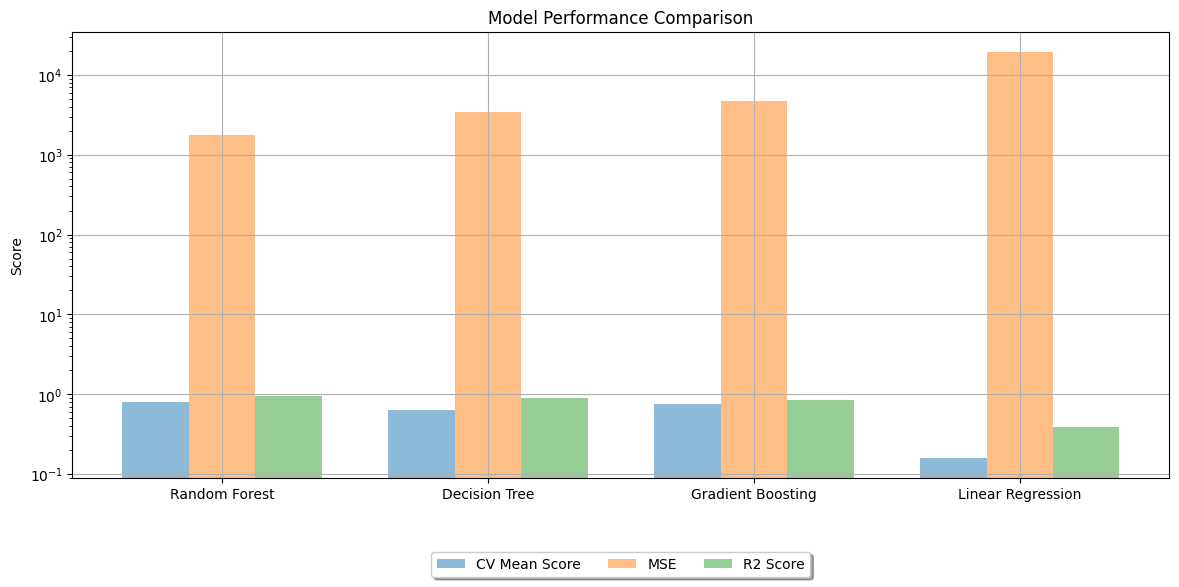

In [8]:
# Convert performance_df Styler object to DataFrame
performance_df = performance_df.data

# Set the positions and width for the bars
pos = list(range(len(performance_df.index)))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each metric
plt.bar([p - width for p in pos], performance_df['CV Mean Score'],
        width, alpha=0.5, label='CV Mean Score')
plt.bar(pos, performance_df['MSE'], width, alpha=0.5, label='MSE')
plt.bar([p + width for p in pos], performance_df['R2 Score'],
        width, alpha=0.5, label='R2 Score')

# Setting the y axis label
ax.set_ylabel('Score')

# Setting the chart's title
ax.set_title('Model Performance Comparison')

# Setting the position of the x ticks
ax.set_xticks([p for p in pos])

# Setting the labels for the x ticks
ax.set_xticklabels(performance_df.index)

# Adding the legend below the chart
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=3)

# Adjust layout to make room for the legend
plt.tight_layout()
# Setting the y-axis to logarithmic scale for better visualization of MSE
plt.yscale('log')
plt.grid()
plt.show()